In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Dropout,Dense, LSTM,TimeDistributed, RepeatVector
from keras.models import Sequential

In [31]:
import os, glob
files_folder = "problem1/"
files = []
for file in glob.glob(os.path.join(files_folder ,"*.txt")):
                      table = pd.read_csv(file , delimiter=',',names=['Doing nothing', 'Eating', 'Ruminating','Walking'], index_col=False)
                      files.append(table)


df = pd.concat(files, keys=['cow {}'.format(i+1) for i in range(len(files))])
df

Doing nothing    Eating  Ruminating   Walking
cow 1  0          0.163131  0.499941    0.000000  0.336928
       1          0.098108  0.650174    0.020977  0.230742
       2          0.550739  0.335149    0.007132  0.106980
       3          0.065699  0.622836    0.074481  0.236985
       4          0.457155  0.318455    0.057907  0.166483
...                    ...       ...         ...       ...
cow 11 5995       0.060640  0.021277    0.903936  0.014147
       5996       0.116282  0.049385    0.778037  0.056296
       5997       0.701440  0.014866    0.239034  0.044660
       5998       0.964299  0.014280    0.007140  0.014280
       5999       0.649368  0.057426    0.228613  0.064593

[66000 rows x 4 columns]

In [32]:
# selecting data of one cow as normal data for feeding to our model
#based on clustering model and data visualiztion, I have noticed that data of cow 3 has less anomalities,
#so i assumed data for this cow as relativly normal data.
train=df.loc['cow 3']
test=df.drop('cow 3')

In [33]:
#this is a lSTM autoencoder,so I need a lookback function for sequencing the data.
#I used LSTM for considering time dependencies.
#as data from sensors is collected every 15 minutes,I decided to take TIME_STEPS = 8, which means that I am analyzing
#the data of cows by considering cow’s behavior during 2 hours.

def create_dataset(X,y, time_steps):
    X1, y1= [],[]
    for i in range(len(X) - time_steps):
        X1.append(X.iloc[i:(i+time_steps)].values)
        y1.append(y.iloc[i+time_steps:i+time_steps+1].values)
        
    return np.array(X1), np.array(y1)
TIME_STEPS = 8
X_train,y_train = create_dataset(train,train, TIME_STEPS)

print(X_train.shape)

(5992, 8, 4)


In [34]:
#LSTM Autoencoder model
model = Sequential()
model.add(LSTM(128, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, activation='relu',return_sequences=False))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu',return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 8, 128)            68096     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 64)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 8, 64)             33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 8, 128)            98816     
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 128)           

In [35]:
history=model.fit(X_train, X_train, epochs=20, batch_size=100, verbose=0, validation_split=0.1).history

Text(0, 0.5, 'Loss')

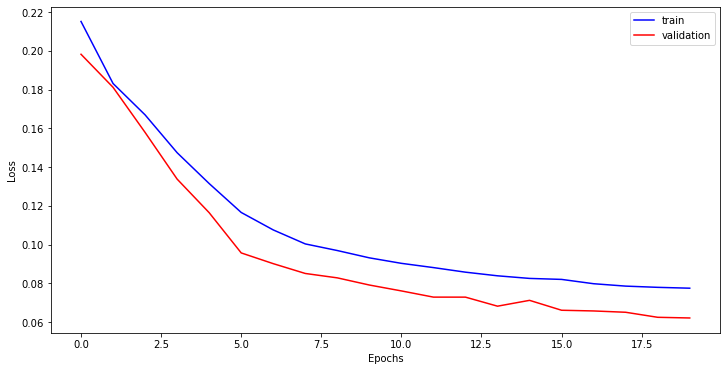

In [36]:
fig,ax=plt.subplots(figsize=(12,6))
ax.plot(history['loss'],'b', label='train')
ax.plot(history['val_loss'],'r', label='validation')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

reconstruction loss threshold: 0.15901301660807954


6

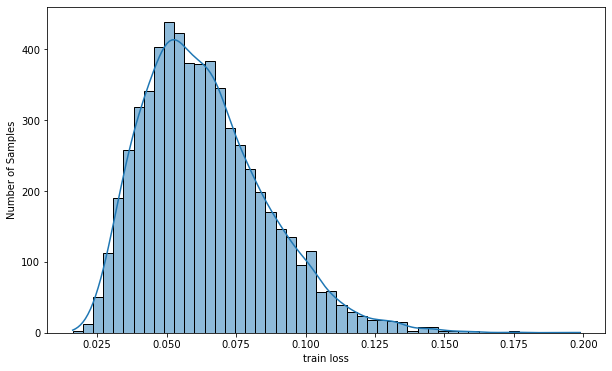

In [37]:
#plotting the distribution of the calculated loss in the training set for determining a suitable threshold value for 
#identifying an anomaly. 
#this threshold should be above the noise level. I assumed that losses above 80 percentile are noises.

X_train_pred=model.predict(X_train)
train_loss=np.mean(np.abs(X_train_pred-X_train), axis=1)

train_loss=pd.DataFrame(train_loss, columns=['Doing nothing', 'Eating', 'Ruminating','Walking'])
train_loss=train_loss.mean(axis=1)
plt.figure(figsize=(10,6))
sns.histplot(train_loss,bins=50, kde=True)
plt.xlabel('train loss')
plt.ylabel('Number of Samples')


threshold = np.max(train_loss)*0.8
print('reconstruction loss threshold: {}'. format(threshold))

train_anomaly=train_loss>threshold
len(train_anomaly[train_anomaly==True])


 anomalis for cow 10 = 117: 
      Doing nothing    Eating  Ruminating   Walking     cow      loss  anomaly
220        0.077835  0.127451    0.446657  0.348056  cow 10  0.188465     True
222        0.014164  0.269950    0.056841  0.659044  cow 10  0.159181     True
237        0.621197  0.086508    0.066990  0.225305  cow 10  0.170226     True
313        0.517726  0.007148    0.467978  0.007148  cow 10  0.162873     True
462        0.209038  0.000000    0.790962  0.000000  cow 10  0.168518     True
...             ...       ...         ...       ...     ...       ...      ...
5897       0.121325  0.234588    0.425438  0.218648  cow 10  0.172329     True
5907       0.152727  0.069126    0.750563  0.027583  cow 10  0.205893     True
5908       0.057476  0.069100    0.845826  0.027598  cow 10  0.204826     True
5909       0.020958  0.146896    0.635669  0.196478  cow 10  0.227142     True
5971       0.040080  0.006680    0.926520  0.026720  cow 10  0.166216     True

[117 rows x 7 columns

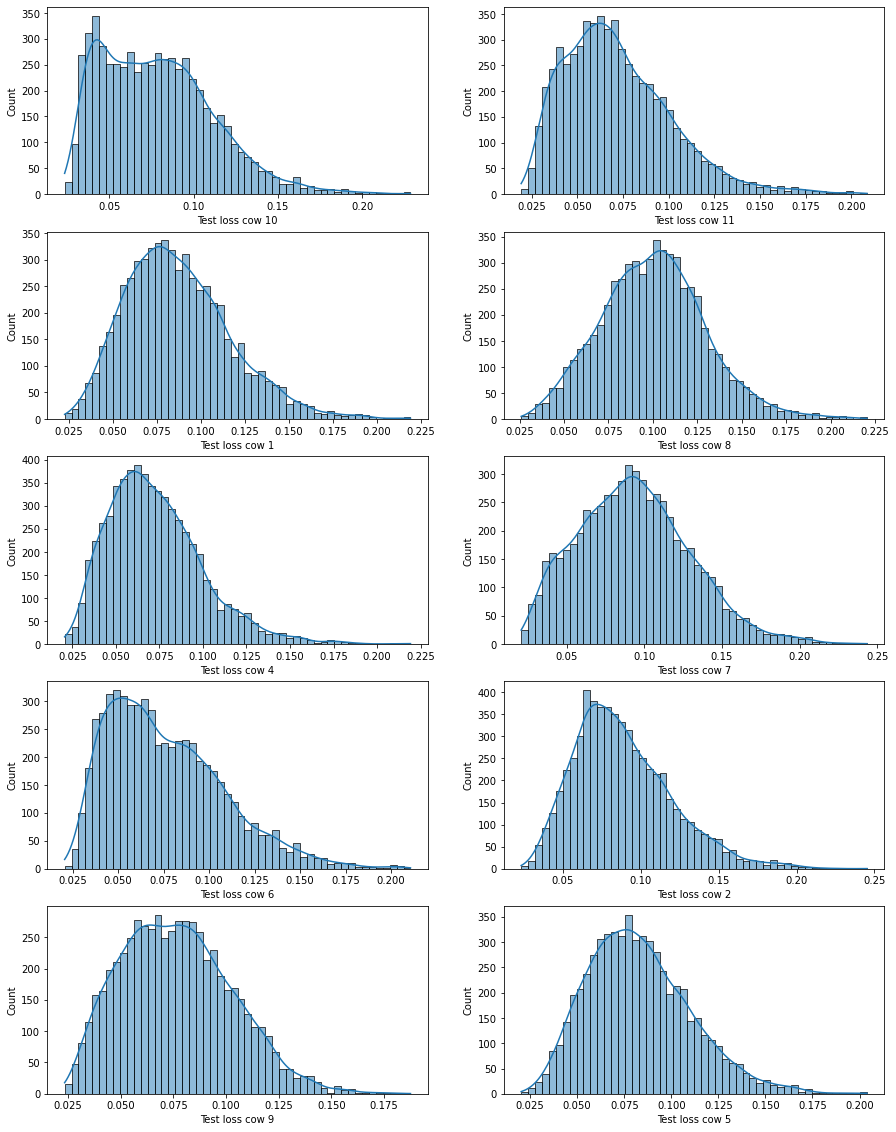

In [38]:
#calculating the reconstruction loss in the test sets to determine when the sensor readings cross the anomaly threshold.
#I took data for each cow as separate test set to analyze each cow behavior and find anomalies for each of them separately,
#to be able to compare their behavior.
test_data_index=list(set(test.index.get_level_values(0)))
fig, subaxes = plt.subplots(5, 2, figsize=(15,20))
anomalies_total_list=[]
test_score_list=[]
for i in range(len(test_data_index)):
    test_df=df.loc[test_data_index[i]]
    X_test,y_test= create_dataset(test_df,test_df,TIME_STEPS)
    X_test_pred = model.predict(X_test)
    test_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)
    test_loss=pd.DataFrame(test_loss, columns=['Doing nothing', 'Eating', 'Ruminating','Walking'])
    test_loss['loss']=test_loss.mean(axis=1)
    plt.subplot(5,2,i+1)
    sns.histplot(test_loss['loss'],bins=50,kde=True)
    plt.xlabel('Test loss {}'.format(test_data_index[i]))
    
    
    
    test_score_df = pd.DataFrame(test_df[TIME_STEPS:])
    test_score_df['cow']=test_data_index[i]
    test_score_df['loss'] = test_loss['loss']
    test_score_df['anomaly'] = test_score_df['loss'] >threshold
    anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
    print('\n anomalis for {} = {}: \n{}'.format(test_data_index[i],len(anomalies), anomalies))
    anomalies_total_list.append(anomalies)
    test_score_list.append(test_score_df)
    
    

In [39]:
anomalies_total=pd.concat(anomalies_total_list)
anomalies_total

,Doing nothing,Eating,Ruminating,Walking,cow,loss,anomaly
220,0.077835,0.127451,0.446657,0.348056,cow 10,0.188465,True
222,0.014164,0.269950,0.056841,0.659044,cow 10,0.159181,True
237,0.621197,0.086508,0.066990,0.225305,cow 10,0.170226,True
313,0.517726,0.007148,0.467978,0.007148,cow 10,0.162873,True
462,0.209038,0.000000,0.790962,0.000000,cow 10,0.168518,True
...,...,...,...,...,...,...,...
5444,0.948064,0.000000,0.007411,0.044525,cow 5,0.164604,True
5499,0.958855,0.008216,0.032929,0.000000,cow 5,0.164466,True
5500,0.869448,0.014484,0.036162,0.079906,cow 5,0.164189,True
5503,0.303003,0.051254,0.219870,0.425873,cow 5,0.160174,True


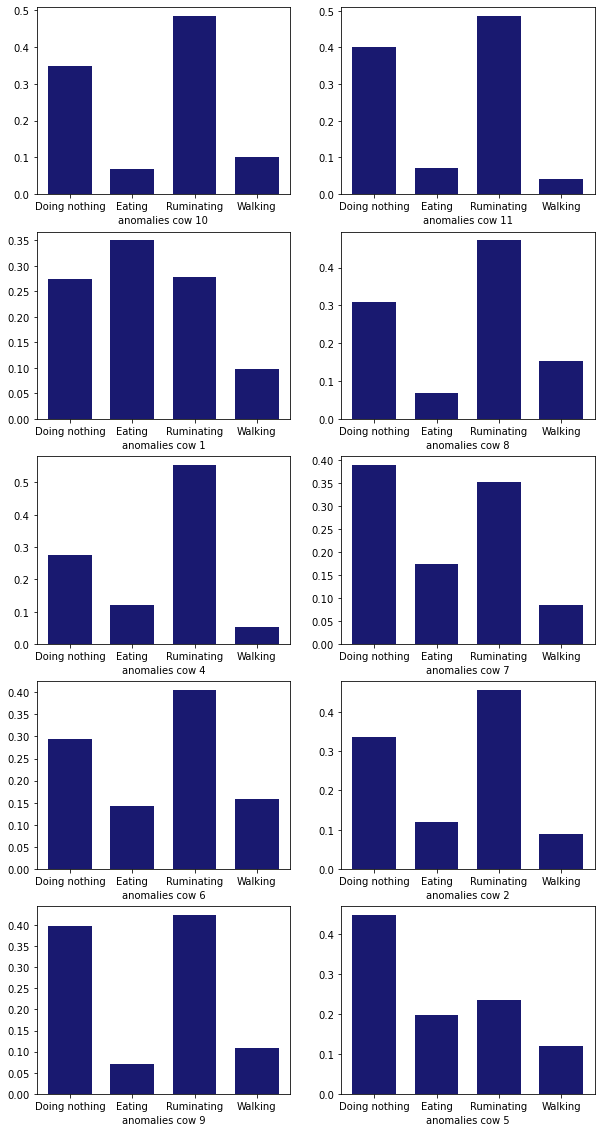

In [40]:
# anomalies in different cows are different. in some cases 'eating' decrease,
#in some other cases 'doing nothing' increase , ... 
fig, subaxes = plt.subplots(5, 2, figsize=(10,20))
for i in range(len(test_data_index)):
    plt.subplot(5,2,i+1)
    plt.bar(x=['Doing nothing', 'Eating', 'Ruminating','Walking'],
            height=list(anomalies_total[['Doing nothing', 'Eating', 'Ruminating','Walking']][anomalies_total['cow']==test_data_index[i]].mean(axis=0))
           ,width=0.7, color='#191970')
    plt.xlabel('anomalies {}'.format(test_data_index[i]))
    

    

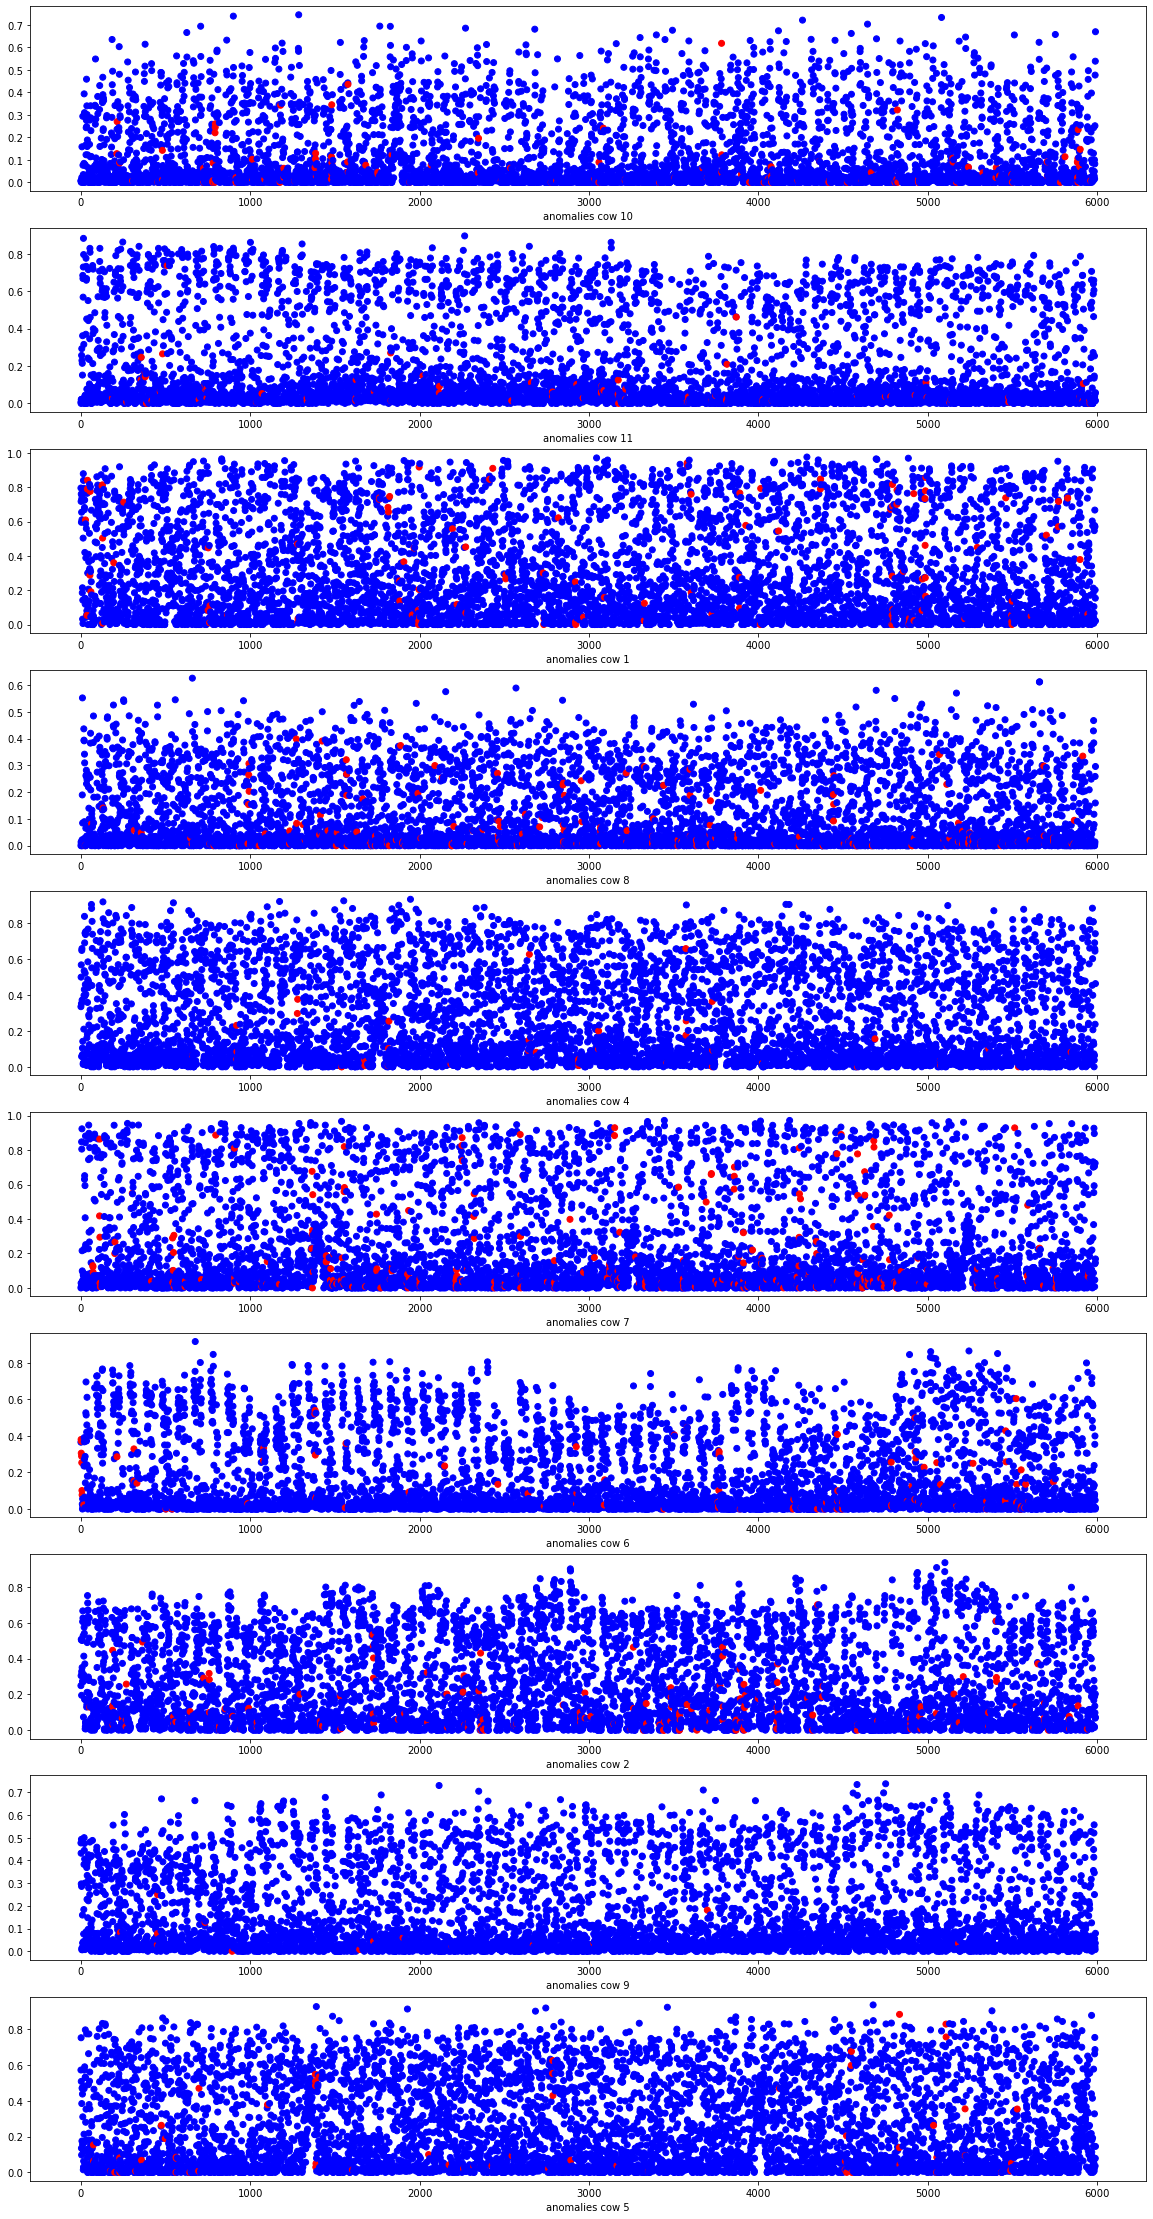

In [42]:
test_score_total=pd.concat(test_score_list)
test_score_total['anomaly_code']=test_score_total['anomaly'].astype(int)

colors = {0:'blue', 1:'red'}
fig, subaxes = plt.subplots(10, 1, figsize=(20,40))
for i in range(len(test_data_index)):
    plt.subplot(10,1,i+1)
    plt.scatter(np.arange(len(test_score_total[test_score_total['cow']==test_data_index[i]])),
                test_score_total[test_score_total['cow']==test_data_index[i]]['Eating'],
                color=test_score_total[test_score_total['cow']==test_data_index[i]]["anomaly"].apply(lambda x: colors[x]))
    plt.xlabel('anomalies {}'.format(test_data_index[i]))
